# Convolutional Neural Networks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.ndimage import convolve, convolve1d

The idea of this project it to get familiar with convolutional neural networks and solve the "cats vs dogs" captcha challenge, which tries to automatically classify images as cats or dogs.

## Getting Started
To get started with Convnets, read up on the concepts in the [Deep Learning Book, Chapters 9.1-9.3](http://www.deeplearningbook.org/contents/convnets.html).
The Stanford course on neural networks also has a [great explanation](http://cs231n.github.io/convolutional-networks/).

### Understanding Convolutions
Before diving into convolutional neural nets, it's a good idea to understand how convolutions work. A convolution is simply a filter (as in signal processing) applied to all positions of a signal. Very simple filters are those that smooth or blurr, and those that compute derivatives.

### 1d convolutions
Let's start with smoothing a 1d signal.

In [3]:
# create a noisy signal
# use a fixed seed for simplicity
rng = np.random.RandomState(0)
noise = rng.normal(size=(200,))
random_walk = np.cumsum(noise)
print(random_walk[: 10])

[ 1.76405235  2.16420955  3.14294754  5.38384074  7.25139873  6.27412085
  7.22420927  7.07285206  6.96963321  7.38023171]


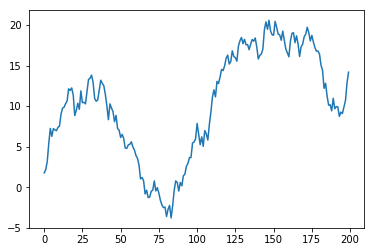

In [4]:
plt.plot(random_walk)
plt.show()

Convolutions in n dimensions are implemented in ``scipy.ndimage.convolve``. Let's start with smoothing our signal. Use ``convolve`` to convolve the signale with a constant filter (``np.ones()``). Start with length 3, and then try different length. Visualize the result of the convolution together with the original signal.

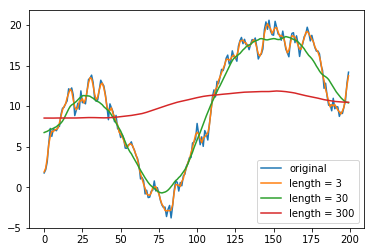

In [22]:
plt.plot(random_walk, label="original")
def do_convolve(length):
    weights = np.ones(length)/length
    conv = convolve(input=random_walk, weights=weights)
    plt.plot(conv, label="length = "+format(length))

do_convolve(3)
do_convolve(30)
do_convolve(300)
plt.legend()
plt.show()

Now let's try a slightly more complicated filter: a Gaussian filter.

array([ 0.00295917,  0.00855174,  0.020991  ,  0.04376295,  0.07749521,
        0.11655688,  0.14890036,  0.1615654 ,  0.14890036,  0.11655688,
        0.07749521,  0.04376295,  0.020991  ,  0.00855174,  0.00295917])

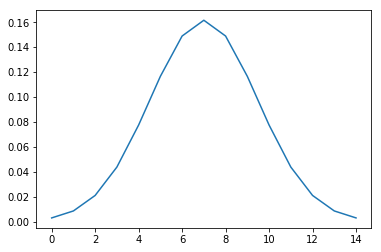

In [16]:
gaussian_filter = np.exp(-np.linspace(-2, 2, 15) ** 2)
gaussian_filter /= gaussian_filter.sum()
plt.plot(gaussian_filter)
gaussian_filter

Convolve the signal with the Gaussian filter and compare the results to the constant filter. What does changing the radius or size of the filter do?

In [52]:
convolve?

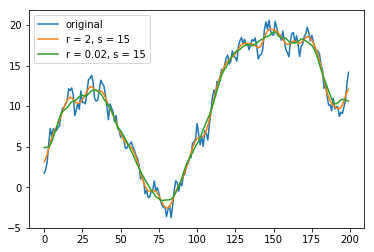

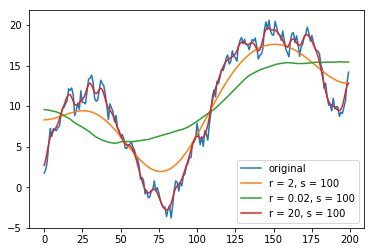

In [47]:
plt.plot(random_walk, label="original")
def do_convolve_gaussian(radius, size):
    gaussian_filter = np.exp(-np.linspace(-radius, radius, size)**2)
    gaussian_filter /= gaussian_filter.sum()
    conv = convolve(input=random_walk, weights=gaussian_filter)
    plt.plot(conv, label="r = "+format(radius)+", s = "+format(size))

do_convolve_gaussian(2, 15)
do_convolve_gaussian(0.02, 15)
plt.legend()
plt.show()

plt.plot(random_walk, label="original")
do_convolve_gaussian(2, 100)
do_convolve_gaussian(0.02, 100)
do_convolve_gaussian(20, 100)
plt.legend()
plt.show()

A somewhat more interesting filter is the derivative. There's many ways to encode a derivative, the simplest is the filter ``[-1, 1]``. Use this filter on the signal.

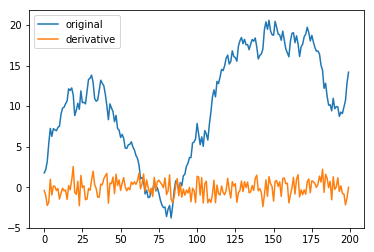

In [64]:
conv = convolve(input=random_walk, weights=[-1, 1])
plt.plot(random_walk, label="original")
plt.plot(conv, label="derivative")
plt.legend()
plt.show()

Sometimes a better way to compute the derivative is to smooth first. Convolutions are associative, meaning applying one filter and then another is the same as first convolving the two filters, then applying the result.

Apply the ``[-1, 1]`` filter to the ``gaussian_filter`` above and visualize the result. Then, convolve the original signal with this smoothed derivative filter.

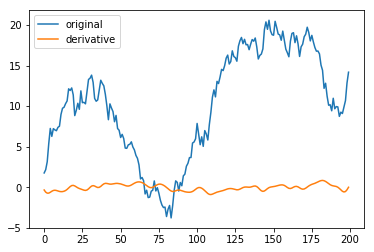

In [58]:
gaussian_filter = np.exp(-np.linspace(-2, 2, 15)**2)
gaussian_filter /= gaussian_filter.sum()
conv = convolve(input=random_walk, weights=gaussian_filter)
conv = convolve(input=conv, weights=[-1, 1])
plt.plot(random_walk, label="original")
plt.plot(conv, label="derivative")
plt.legend()
plt.show()

### 2d convolutions
Next, we'll apply the same principles to a 2d signal.


In [1]:
from scipy.misc import imread
image = imread("thisisdog.png")O
plt.imshow(image)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


NameError: name 'plt' is not defined

For simplicity, convert to grayscale for now:

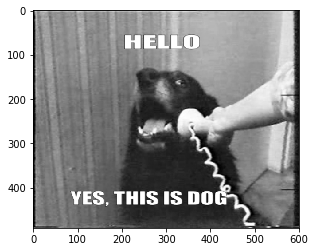

In [82]:
gray = image.mean(axis=2)
plt.imshow(gray, cmap=plt.cm.Greys_r)
plt.show()

Creating a 2d Gaussian filter from the 1d Gaussian filter above:

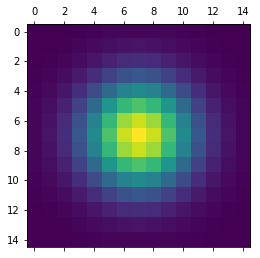

In [76]:
gaussian_filter = np.exp(-np.linspace(-2, 2, 15)**2)
gaussian_filter /= gaussian_filter.sum()
gaussian_2d = gaussian_filter * gaussian_filter[:, np.newaxis]
plt.matshow(gaussian_2d)
plt.show()

Now smooth the image with the 2d Gaussian filter:

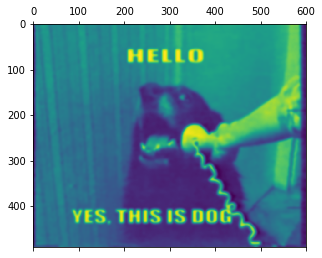

In [81]:
conv = convolve(input=gray, weights=gaussian_2d)
plt.matshow(conv)
plt.show()

Computing gradients in an image is the same as doing "edge detection". Convolve the 2d Gaussian with the ``[-1, 1]`` filter to get an edge detection filter. Then run the filter on the image. Create filters for both horizontal and vertical edge detection.

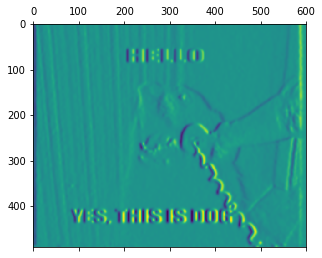

In [86]:
conv = convolve(input=gray, weights=gaussian_2d)
conv = convolve(input=conv, weights=[[-1, 1],[-1, 1]])
plt.matshow(conv)
plt.show()

# A baseline network on MNIST
For many years, the MNIST dataset of handwritten digits (much larger than the ``digits`` dataset we were using) was a standard benchmark.
Start by applying a standard Multilayer perceptron (no convolutions) to the MNIST dataset as a baseline.
If you get stuck, you can consult the example [here](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py)

In [10]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout

batch_size = 128
num_classes = 10
epochs = 20

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# build sequential model as yesterday
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer="RMSprop", metrics=['accuracy'])

history = model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [=======================

# Convolutional neural networks with Keras

Now compare this to a convolutional neural network with keras.
Again you can use the ``Sequential`` model, but this time we are using the Conv2D layers and MaxPooling2D layers (see keras docs).
If you get stuck, you can look at [this example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).

In [12]:
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# The cats and dogs dataset.

You could try to learn a network like this on the cats and dogs dataset.
However, there is unlikely to be enough data in the dataset. Instead, we will use a neural network that was trained on the much larger "imagenet" dataset.

Start by downloading the cats and dogs data here:

https://www.kaggle.com/c/dogs-vs-cats/data

or if you don't have a kaggle account here:

https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

Then load one of the models shipped with keras. Start with VGG 16:
https://keras.io/applications/#vgg16

In [14]:
model = keras.applications.vgg16.VGG16()

   163840/553467096 [..............................] - ETA: 2:54:20

KeyboardInterrupt: 

In [ ]:
# Prepare data similar to MNIST above
from keras.applications.vgg16 import preprocess_input
X_pre = preprocess_input(X)


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
# use the vgg net to extract features:
features = model.predict(X_pre)

In [2]:
preprocess_input?

Object `preprocess_input` not found.


In [3]:
from keras.applications.resnet50 import preprocess_input
preprocess_input?

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
